<a href="https://colab.research.google.com/github/Jungin1020/Aiffel_exp/blob/main/2022_01_27_exp_8_news_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Extractive/Abstractive summarization
2. text normalization
3. Attention Mechanism

#Text Summarization
긴 길이의 문서 원문을 핵심 주제만으로 구성 된 짧은 문장들로 변환

###1. Extractive Summarizatioin
문장들을 추출해서 요약

###2. Abstractive Summarization
원문으로부터 내용이 요약된 새로운 문장 생성
문장 분류(Text Classification) + 자연어 생성(NLG)

seq2seq - 주로 뉴럴 기계번역에 사용

원문을 요약문으로 번역한다고 생각

##LSTM
hidden state 와 cell state도 사용

##Attention Mechanism

컨텍스트 정보에 많은 정보 손실이 일어나는 다른 RNN 계열 인공신경망(바닐라,LSTM,GRU)와 달리 인코더의 모든 step의 hidden state 정보가 컨텍스트에 전부 반영

In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [ ]:
#!mkdir -p /content/drive/MyDrive/aiffel/news_summarization/data

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

In [ ]:
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv', filename="news_summary_more.csv")

data = pd.read_csv("news_summary_more.csv", encoding='iso-8859-1')
print('num of samples: ',len(data))

num of samples:  98401


In [ ]:
data.sample(10)

,headlines,text
8185,Chinese company unveils plan to provide free W...,Chinese internet technology company LinkSure N...
82419,Woman dies after falling off cliff while takin...,A 35-year-old woman named Sushma Jain died aft...
46003,Would have resigned if I was in Jaitley's posi...,Speaking at an interactive session on India's ...
22703,Shikhar simply doesn't want to change: Gavaska...,Slamming opener Shikhar Dhawan's approach in T...
14246,Cash-strapped Pakistan to approach IMF for bai...,The Pakistan government has decided to approac...
48954,Vietnam activist jailed for 14yrs for live-str...,A Vietnamese court has sentenced an activist t...
57351,26/11 mastermind leads rally against US' Jerus...,Mumbai attack mastermind and Jamaat-ud-Dawah (...
6199,I don't know what Shastri has achieved in his ...,Criticising coach Ravi Shastri for his stateme...
90182,India's Shiva Thapa wins silver at Asian Boxin...,Boxer Shiva Thapa won a silver medal at the As...
38050,Break-up with Sushant didn't affect my profess...,Opening up about her break-up with actor Susha...


In [ ]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


##중복 샘플 유무 확인 nunique()
##drop_duplicates로 쉽게 삭제

In [ ]:
print('text 중복 제외: ',data['headlines'].nunique())
print('summary 중복 제외: ',data['text'].nunique())

text 중복 제외:  98280
summary 중복 제외:  98360


In [ ]:
data.drop_duplicates(subset = ['headlines'], inplace=True)
data.drop_duplicates(subset = ['text'], inplace=True)
print('num of samples: ',len(data))

num of samples:  98262


##데이터프레임에 null값이 있는지 확인할 땐 isnull()

In [ ]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


##데이터프레임에서 null값 제거할 때는 dropna()

In [ ]:
data.dropna(axis=0, inplace=True)
print('num of data: ',len(data))

num of data:  98262


##텍스트 정규화
같은 의미인데 다르게 쓴 것들 정리

In [ ]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                "you're": "you are", "you've": "you have"}

print('num of norm_dict: ',len(contractions))

num of norm_dict:  120


##stopwords 불용어
text 전처리에만 사용
summary에는 남아있는게 좋다

In [ ]:
print('num of stopwords: ',len(stopwords.words('english')))
print(stopwords.words('english'))

num of stopwords:  179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 

In [ ]:
def preprocess_sentence(sentence, remove_stopwords=True):
  sentence = sentence.lower() # 텍스트 소문자
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
  sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
  sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
  sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
  sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
  sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
  sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
  # 불용어 제거 (Text)
  if remove_stopwords:
    tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
  else:
    tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
      
  return tokens

In [ ]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print('text: ',preprocess_sentence(temp_text))
print('summary: ',preprocess_sentence(temp_summary,False))

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary:  great way to start the day


##데이터 전체에 대한 전처리

In [ ]:
clean_text = []

for s in data['text']:
  clean_text.append(preprocess_sentence(s))

print('Text 전처리 후: ',clean_text[:5])

Text 전처리 후:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure c

In [ ]:
clean_head = []

for s in data['headlines']:
  clean_head.append(preprocess_sentence(s,False))

print('Headline 전처리 후: ',clean_head[:5])

Headline 전처리 후:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


##텍스트 정제 과정 거친 후 다시 빈 샘플 있는지 확인
##정제 과정에서 단어가 사라지는 경우가 있음

In [ ]:
data['text'] = clean_text
data['headlines'] = clean_head

data.replace('',np.nan, inplace=True) #빈 값을 Null 값으로 변환

In [ ]:
data.isnull().sum() #null 값이 있는지 확인

headlines    0
text         0
dtype: int64

In [ ]:
data.dropna(axis=0, inplace=True)
print('전체 샘플 수: ', len(data))

전체 샘플 수:  98262


## 훈련에 사용할 샘플 최대 길이 정하기

text min len: 1
text max len: 60
text mean len: 35.10029309397326
head min len: 1
head max len: 16
head mean len: 9.299444342675704


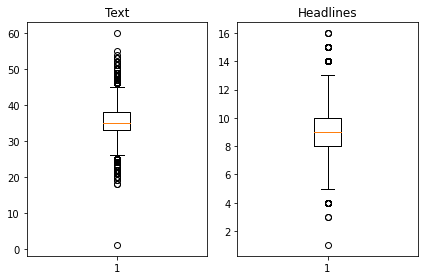

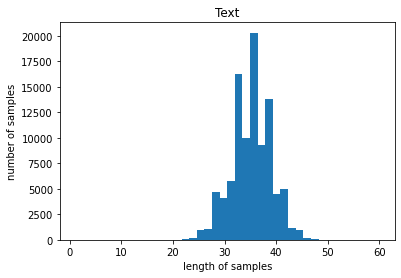

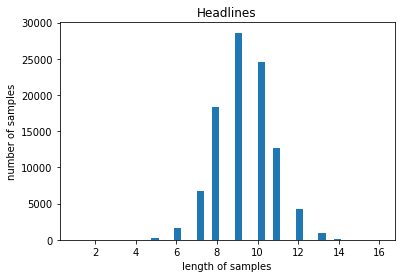

In [ ]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
head_len = [len(s.split()) for s in data['headlines']]

print('text min len: {}'.format(np.min(text_len)))
print('text max len: {}'.format(np.max(text_len)))
print('text mean len: {}'.format(np.mean(text_len)))
print('head min len: {}'.format(np.min(head_len)))
print('head max len: {}'.format(np.max(head_len)))
print('head mean len: {}'.format(np.mean(head_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(head_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(head_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
text_max_len = 40
head_max_len = 9

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
      cnt = cnt+1
  print('전체 샘플 중 길이 %s 이하인 샘플 비율: %s'%(max_len, (cnt/len(nested_list))))
  

In [ ]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(head_max_len, data['headlines'])

전체 샘플 중 길이 40 이하인 샘플 비율: 0.92383627444994
전체 샘플 중 길이 9 이하인 샘플 비율: 0.5666585251674096


In [ ]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= head_max_len)]
print('전체 샘플 수: ',len(data))

전체 샘플 수:  51435


In [ ]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...
18,how long can tolerate congress leaders potshot...,days threatened step post congress mlas contin...,sostoken how long can tolerate congress leader...,how long can tolerate congress leaders potshot...
19,odisha cm patnaik controls mining mafia union ...,union minister dharmendra pradhan wednesday cl...,sostoken odisha cm patnaik controls mining maf...,odisha cm patnaik controls mining mafia union ...
20,think the opposition even dreams about me pm modi,claiming dearth ideas among opposition parties...,sostoken think the opposition even dreams abou...,think the opposition even dreams about me pm m...


##인코더의 입력, 디코더의 입력, 레이블을 넘파이로 저장

In [ ]:
encoder_input = np.array(data["text"])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])


In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[35367 29487  9468 ... 34341  2941 33559]


In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
n_of_val = int(len(encoder_input)*0.2)
print('num of test data: ', n_of_val)

num of test data:  10287


In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('num of train data: ',len(encoder_input_train))
print('num of train label: ',len(decoder_input_train))
print('num of test data: ',len(encoder_input_test))
print('num of test label: ',len(decoder_input_test))

num of train data:  41148
num of train label:  41148
num of test data:  10287
num of test label:  10287


##단어 집합 만들기

In [ ]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데어터로부터 단어 집합 생성


In [ ]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) #단어의 수
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in src_tokenizer.word_counts.items():
  total_freq = total_freq + value

  if (value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('vocabulary의 크기: ', total_cnt)
print('빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('vocab에서 희귀 단어 제외하고 남는 vocab의 크기 %s'%(total_cnt - rare_cnt))
print('vocab에서 희귀 단어의 비율: ',(rare_cnt / total_cnt)*100)
print('전체 빈도에서 희귀 단어 빈도 비율: ',(rare_freq / total_freq)*100)

vocabulary의 크기:  53862
빈도가 6번 이하인 희귀 단어의 수: 37576
vocab에서 희귀 단어 제외하고 남는 vocab의 크기 16286
vocab에서 희귀 단어의 비율:  69.7634696075155
전체 빈도에서 희귀 단어 빈도 비율:  5.3933918321753


In [ ]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) #token 정의할 때 num_words 값 정해주면 단어 집합 크기 제한 가능
src_tokenizer.fit_on_texts(encoder_input_train) #단어 집합 재생성

In [ ]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
                                                      
print(encoder_input_train[:3])

[[9, 46, 1, 117, 39, 2335, 3353, 283, 143, 1491, 29, 23, 2752, 313, 832, 3666, 6433, 594, 316, 181, 5386, 5020, 44, 5275, 26, 3353, 283, 5, 6593, 4], [282, 584, 6179, 4241, 853, 142, 6179, 403, 3081, 584, 509, 1429, 514, 501, 529, 5103, 80, 1575, 4307, 5103, 1297, 2093, 414], [2877, 453, 100, 2800, 6956, 7276, 822, 259, 2093, 453, 84, 2800, 527, 18, 2877, 1492, 100, 413, 1357, 167, 919, 4242, 139, 553, 2470, 1040, 601, 36, 3807, 1122, 818, 1]]


In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) #단어의 수
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tar_tokenizer.word_counts.items():
  total_freq = total_freq + value

  if (value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('vocabulary의 크기: ', total_cnt)
print('빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('vocab에서 희귀 단어 제외하고 남는 vocab의 크기 %s'%(total_cnt - rare_cnt))
print('vocab에서 희귀 단어의 비율: ',(rare_cnt / total_cnt)*100)
print('전체 빈도에서 희귀 단어 빈도 비율: ',(rare_freq / total_freq)*100)

vocabulary의 크기:  24163
빈도가 5번 이하인 희귀 단어의 수: 16839
vocab에서 희귀 단어 제외하고 남는 vocab의 크기 7324
vocab에서 희귀 단어의 비율:  69.6891942225717
전체 빈도에서 희귀 단어 빈도 비율:  8.330399359480909


In [ ]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) #token 정의할 때 num_words 값 정해주면 단어 집합 크기 제한 가능
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)


print('input')
print('input',decoder_input_train[:5])
print('target')
print('decoder',decoder_target_train[:5])

input
input [[1, 21, 39, 6, 1100], [1, 554, 10, 320], [1, 636, 1354, 343, 4, 1623, 1323, 343, 688], [1, 293, 284, 4, 1130, 3], [1, 1248, 17, 6, 117]]
target
decoder [[21, 39, 6, 1100, 2], [554, 10, 320, 2], [636, 1354, 343, 4, 1623, 1323, 343, 688, 2], [293, 284, 4, 1130, 3, 2], [1248, 17, 6, 117, 2]]


In [ ]:
print(len(decoder_input_train))
print(len(decoder_target_train))
print(len(decoder_input_test))
print(len(decoder_target_test))

41148
41148
10287
10287


## 훈련, 테스트 데이터의 요약문 길이가 1인 경우 drop에 저장해서 삭제

In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터 수: ',len(drop_train))
print('삭제할 테스트 데이터 수: ',len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터 수: ', len(encoder_input_train))
print('훈련 레이블 수: ', len(decoder_target_train))
print('테스트 데이터 수: ', len(encoder_input_test))
print('훈련 레이블 수: ', len(decoder_target_test))

삭제할 훈련 데이터 수:  8
삭제할 테스트 데이터 수:  5
훈련 데이터 수:  41140
훈련 레이블 수:  41140
테스트 데이터 수:  10282
훈련 레이블 수:  10282


##패딩하기

In [ ]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=head_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=head_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=head_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=head_max_len, padding='post')

##모델 설계하기

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#인코더 설계 시작
embedding_dim = 128
hidden_size = 256 #LSTM에서 얼만큼 수용력을 가질지, LSTM의 용량 크기나 뉴런 개수와 비슷

#인코더
encoder_inputs = Input(shape=(text_max_len,))
#인코더 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
#인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
#인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
#인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

#드롭아웃?? recurrent dropout, time step....

##디코더 설계

In [ ]:
decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs,_,_ = decoder_lstm(dec_emb, initial_state=[state_h,state_c])

In [ ]:
decoder_softmax_layer = Dense(tar_vocab,activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      1024000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

##Attention

In [ ]:
from tensorflow.keras.layers import AdditiveAttention

attn_layer = AdditiveAttention(name='attention_layer')

attn_out = attn_layer([decoder_outputs, encoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      1024000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

##모델 훈련

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
                    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
                    batch_size=256, callbacks=[es], epochs=15)

Epoch 1/15
161/161 [==============================] - 169s 968ms/step - loss: 4.6785 - val_loss: 4.3653
Epoch 2/15
161/161 [==============================] - 155s 960ms/step - loss: 4.2775 - val_loss: 4.1105
Epoch 3/15
161/161 [==============================] - 154s 960ms/step - loss: 4.0111 - val_loss: 3.8437
Epoch 4/15
161/161 [==============================] - 154s 955ms/step - loss: 3.7860 - val_loss: 3.7023
Epoch 5/15
161/161 [==============================] - 153s 953ms/step - loss: 3.6180 - val_loss: 3.5649
Epoch 6/15
161/161 [==============================] - 153s 953ms/step - loss: 3.4707 - val_loss: 3.4535
Epoch 7/15
161/161 [==============================] - 153s 950ms/step - loss: 3.3481 - val_loss: 3.3895
Epoch 8/15
161/161 [==============================] - 154s 956ms/step - loss: 3.2430 - val_loss: 3.3177
Epoch 9/15
161/161 [==============================] - 152s 945ms/step - loss: 3.1487 - val_loss: 3.2663
Epoch 10/15
161/161 [==============================] - 151s 938m

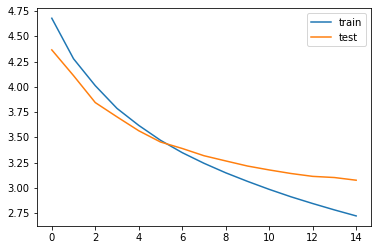

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

##인퍼런스 모델 구현
정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야하기 때문에 인퍼런스를 위한 모델 설계를 별도로 해주어야 함 

In [ ]:
scr_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

In [ ]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = [decoder_state_input_h, decoder_state_input_c])


In [ ]:
#어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

#디코더 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

#최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)

##단어 시퀀스를 완성하는 함수

In [ ]:


def decode_sequence(input_seq):
  e_out, e_h, e_c = encoder_model.predict(input_seq)#입력으로부터 인코더의 상태를 얻음
  #<SOS>에 해당하는 토큰 생성
  target_seq = np.zeros((1,1))
  target_seq[0,0] = tar_word_to_index['sostoken']

  stop_condition = False
  decoded_sentence=''
  while not stop_condition:
    #stop_condition이 True가 될 때까지 무한루프
    output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
    sampled_token_index = np.argmax(output_tokens[0,-1,:])
    sampled_token = tar_index_to_word[sampled_token_index]

    if (sampled_token!='eostoken'):
      decoded_sentence += ' '+sampled_token

    if (sampled_token=='eostoken' or len(decoded_sentence.split()) >= (head_max_len-1)):
      stop_condition = True #<eso>에 도달하거나 최대길이 넘으면 중단

    target_seq = np.zeros((1,1)) # 길이가 1인 타겟 시퀀스를 업데이트
    target_seq[0,0] = sampled_token_index

    e_h, e_c = h, c #상태 업데이트

  return decoded_sentence




##모델 테스트하기

In [ ]:
def seq2text(input_seq):
  temp=''
  for i in input_seq:
    if(i!=0):
      temp = temp +scr_index_to_word[i]+' '
  return temp

def seq2summary(input_seq):
  temp=''
  for i in input_seq:
    if((i != 0 and i != tar_word_to_index['sostoken']) and i != tar_word_to_index['eostoken']):
      temp = temp +tar_index_to_word[i]+' '
  return temp

In [ ]:
#실제 요약, 예측 요약 비교하기
for i in range(50,100):
  print('원문: ', seq2text(encoder_input_test[i]))
  print('실제 요약: ', seq2summary(decoder_input_test[i]))
  print('예측 요약: ', decode_sequence(encoder_input_test[i].reshape(1,text_max_len)))
  print('\n')

원문:  us president donald trump thursday said immigrants protected deferred action childhood program nothing worry least trump administration scrapped called program tuesday gave congress six months pass law regulate status lakh immigrants 
실제 요약:  should not about status trump 
예측 요약:   trump calls for us


원문:  annual cultural festival iit bombay indigo bring british progressive metal band india debut december jordan mike band known live set receiving wide critical indigo students colleges nationwide 
실제 요약:  to indigo event 
예측 요약:   iit website hacked to


원문:  number north entering thailand illegally china surged recent months amid increasing tensions korean peninsula thailand immigration officials said average north arriving country week surge come despite controls north korea border china 
실제 요약:  north to thailand each week 
예측 요약:   china to hold north korea


원문:  english third division side midfielder joe survived cancer twice last three years played cup match stadium wednesd

##추출적 요약 해보기
summarize는 문장 토큰화 하지 않아도 내부적으로 토큰화 수행, 문장 구분 되어있지 않은 원문 바로 입력 가능

In [ ]:
!pip install summa
import requests
from summa.summarizer import summarize

     |████████████████████████████████| 54 kB 1.9 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=c5519287fc25cb474c35d5b1ae6e18ec5671829df66640dece26c787708a34f1
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [ ]:
data.head()

,headlines,text,decoder_input,decoder_target
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...
18,how long can tolerate congress leaders potshot...,days threatened step post congress mlas contin...,sostoken how long can tolerate congress leader...,how long can tolerate congress leaders potshot...
19,odisha cm patnaik controls mining mafia union ...,union minister dharmendra pradhan wednesday cl...,sostoken odisha cm patnaik controls mining maf...,odisha cm patnaik controls mining mafia union ...
20,think the opposition even dreams about me pm modi,claiming dearth ideas among opposition parties...,sostoken think the opposition even dreams abou...,think the opposition even dreams about me pm m...


In [ ]:
data['text']

3        aegon life iterm insurance plan customers enjo...
10       two minor cousins uttar pradesh gorakhpur alle...
18       days threatened step post congress mlas contin...
19       union minister dharmendra pradhan wednesday cl...
20       claiming dearth ideas among opposition parties...
                               ...                        
98394    enforcement directorate summoned jammu kashmir...
98395    pakistan started building nearly kilometer fen...
98396    crpf jawan tuesday axed death sharp edged weap...
98398    according reports new version science fiction ...
98400    madhesi morcha alliance seven political partie...
Name: text, Length: 51435, dtype: object

In [ ]:
mystr = ''
for i in range(len(data)):
  mystr += str(data['text'][i:i+1]) + '\n'

with open('corpus.txt','w',encoding='utf-8') as f:
  f.write(mystr)


In [ ]:
r = open('corpus.txt', mode='r', encoding='utf-8')
r.readlines()

['3    aegon life iterm insurance plan customers enjo...\n',
 'Name: text, dtype: object\n',
 '10    two minor cousins uttar pradesh gorakhpur alle...\n',
 'Name: text, dtype: object\n',
 '18    days threatened step post congress mlas contin...\n',
 'Name: text, dtype: object\n',
 '19    union minister dharmendra pradhan wednesday cl...\n',
 'Name: text, dtype: object\n',
 '20    claiming dearth ideas among opposition parties...\n',
 'Name: text, dtype: object\n',
 '21    indian space research organisation wednesday u...\n',
 'Name: text, dtype: object\n',
 '22    least people killed others injured saudi arabi...\n',
 'Name: text, dtype: object\n',
 '23    reliance industries chairman mukesh ambani dau...\n',
 'Name: text, dtype: object\n',
 '27    stand captain rohit sharma become th indian cr...\n',
 'Name: text, dtype: object\n',
 '28    batsman shubman gill become th cricketer repre...\n',
 'Name: text, dtype: object\n',
 '29    investigators searching lost plane carrying ar...\n',

In [ ]:
from matplotlib import lines
with open('corpus.txt','r') as f:
  lines = f.readlines() 
with open('corpus.txt','w') as f:
  for line in lines:
    if not 'Name: text, dtype: object\n':
      f.write(line)

https://sikaleo.tistory.com/63

In [ ]:
print(summarize('corpus.txt',ratio=0.005))

In [ ]:
data.type()

AttributeError: ignored

#회고
### 추출적 요약 인코딩 과정에서 'Name: text, dtype: object\n' < 이런게 딸려와서 summarizer 함수가 작동하지 않았다.
### 데이터 전처리부터 인코딩, 디코딩 과정이 익숙하지 않아 너무 복잡하게 느껴졌다ㅜ
###cv로 가야겠다는 계기가 된 익스였다.... 자연어 안녕